In [1]:
import pandas
import seml
import matplotlib.pyplot as plt

In [2]:
result = seml.get_results("datasetGPU", to_data_frame = True)

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

In [3]:
result.tail()

,_id,config.overwrite,config.db_collection,config.batch_size,config.layerwise,config.model_file,config.number_forward_passes,config.on_GPU,config.params.number_layers,config.seed,result.name,result.power,result.model,result.power_layerwise,result.type,config.params.hidden_size,config.params.model_index
98,112,112,datasetGPU,1,True,dataset.models.pretrained,10000,True,NaN,90826286,ResNetRS101,1.240943e-06,"{""class_name"": ""Functional"", ""config"": {""name""...","[9.506001814035177e-10, 1.936359064390964e-09,...",pretrained,NaN,30.0
99,118,118,datasetGPU,1,True,dataset.models.pretrained,10000,True,NaN,140526764,ResNetRS50,6.535860e-07,"{""class_name"": ""Functional"", ""config"": {""name""...","[9.690616255444419e-10, 2.0114537668823597e-09...",pretrained,NaN,36.0
100,119,119,datasetGPU,1,True,dataset.models.pretrained,10000,True,NaN,166554717,VGG16,1.819014e-07,"{""class_name"": ""Functional"", ""config"": {""name""...","[1.0528767679112158e-09, 4.823263512983056e-09...",pretrained,NaN,37.0
101,120,120,datasetGPU,1,True,dataset.models.pretrained,10000,True,NaN,537085794,VGG19,2.121304e-07,"{""class_name"": ""Functional"", ""config"": {""name""...","[1.0896660015224284e-09, 4.831665201369126e-09...",pretrained,NaN,38.0
102,121,121,datasetGPU,1,True,dataset.models.pretrained,10000,True,NaN,892222332,Xception,7.870769e-07,"{""class_name"": ""Functional"", ""config"": {""name""...","[1.6817995366140147e-09, 4.7364290502746865e-0...",pretrained,NaN,39.0


In [4]:
import tensorflow as tf


In [5]:
result["model"] = result.apply(lambda x: tf.keras.models.model_from_json(x["result.model"]), axis = 1)

2022-06-22 18:47:34.077294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 18:47:36.411555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10410 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


# Data exploration

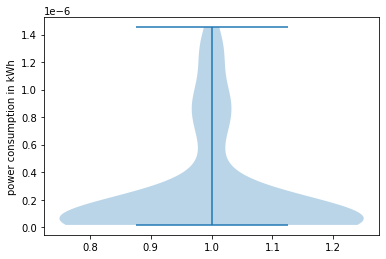

In [35]:
plt.violinplot(result["result.power"])
plt.ylabel("power consumption in kWh")
plt.show()


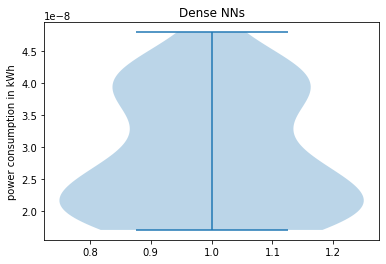

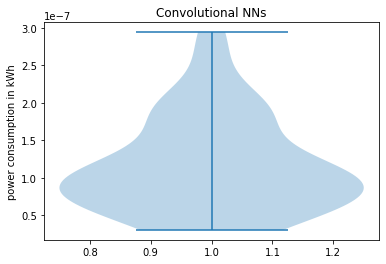

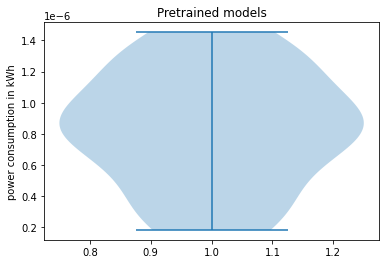

In [40]:
result_dense = result[result.loc[:,"config.model_file"] == "dataset.models.dense"]
result_conv = result[result.loc[:,"config.model_file"] == "dataset.models.conv"]
result_pretrained = result[result.loc[:,"config.model_file"] == "dataset.models.pretrained"]
results = [result_dense, result_conv, result_pretrained]
result_names = ["Dense NNs", "Convolutional NNs", "Pretrained models"]
for res,name in zip(results, result_names):
    plt.violinplot(res["result.power"])
    plt.ylabel("power consumption in kWh")
    plt.title(name)
    plt.show()



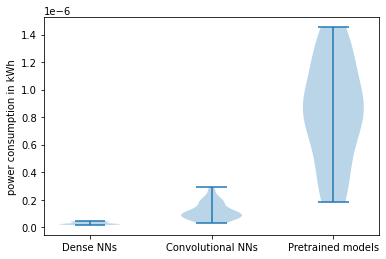

In [70]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.violinplot([result_dense["result.power"], result_conv["result.power"], result_pretrained["result.power"]])
plt.ylabel("power consumption in kWh")
#ax1.set_ylim(0,2e-8)
ax1.set_xticks([1,2,3], labels = ["Dense NNs", "Convolutional NNs", "Pretrained models"])
fig.show()

In [7]:
min(result["result.power"])

1.7012392257888938e-08

In [8]:
max(result["result.power"])

1.4527379637559022e-06

Our data set consists of many simple models with a relative small energy consumption and some pretrained and more complex models that have an energy consumption up to a 100 times higher

## Are FLOPs and power consumption correlated?
One first baseline for the power consumption of a forwar pass could be the number of floating point operations. The advantage of this metric is that the number of FLOPs can be easily computed by existing tools (without the need of actually running a forward pass).

In [9]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
    """ Calculates the floating point operations per second for a given model.

    Parameters:
    -----------
        model:
            ML model that should be measured (has to be callable on input)

    Returns:
    ----------
        float: FLOPs
    """
    forward_pass = tf.function(
        model.call,
        input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

    graph_info = profile(forward_pass.get_concrete_function().graph,
                         options=ProfileOptionBuilder.float_operation())

    # The //2 is necessary since `profile` counts multiply and accumulate
    # as two flops, here we report the total number of multiply accumulate ops
    flops = graph_info.total_float_ops // 2
    return flops

In [10]:
result["FLOPs"] = result.apply(lambda x: get_flops(x["model"]), axis = 1)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

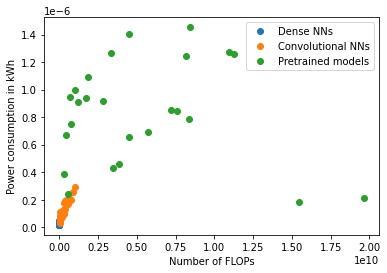

In [11]:
result_dense = result[result.loc[:,"config.model_file"] == "dataset.models.dense"]
result_conv = result[result.loc[:,"config.model_file"] == "dataset.models.conv"]
result_pretrained = result[result.loc[:,"config.model_file"] == "dataset.models.pretrained"]

for x, name in zip([result_dense, result_conv, result_pretrained], ["Dense NNs", "Convolutional NNs", "Pretrained models"]):
    plt.plot(x["FLOPs"], x["result.power"], "o", label = name)
plt.legend()
plt.xlabel("Number of FLOPs")
plt.ylabel("Power consumption in kWh")
plt.show()

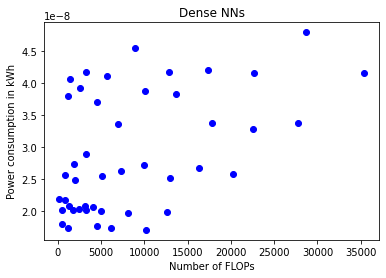

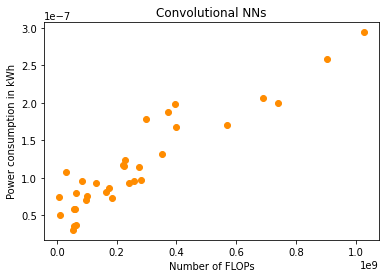

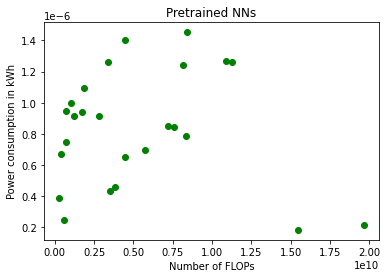

In [12]:
def plot_FLOPS(data, color, title):
    plt.plot(data["FLOPs"], data["result.power"], "o", color = color)
    plt.xlabel("Number of FLOPs")
    plt.ylabel("Power consumption in kWh")
    plt.title(title)
    plt.show()

plot_FLOPS(result_dense, "blue", "Dense NNs")
plot_FLOPS(result_conv, "darkorange", "Convolutional NNs")
plot_FLOPS(result_pretrained, "green", "Pretrained NNs")

One can see that (especially for more complicated models) the number of FLOPs does not seem to be correlated with the power consumption in our dataset

## Layerwise power consumption vs. combined power consumption
In our dataset we measured the combined power consumption for a forward pass (through all layers) and the power consumption for a forward pass through each layer, individually.
We will now investigate if the combined power consumption is close to the sum of the power consumption of every layer.

In [13]:
result["power_additive"] = result.apply(lambda x: sum(x["result.power_layerwise"]), axis = 1)

In [14]:
result["additivity_factor"] = result.apply(lambda x: x["result.power"]/x["power_additive"], axis = 1)

The additivity_factor of a model $M$ consisting of layers $l_1, \dots, l_n$ is defined as
$$\text{additivity_factor}(M) = \frac{P(M)}{\sum_{l \in M} P(l)}$$
where $P(x)$ denotes the measured power consumption of a forward pass through $x$.

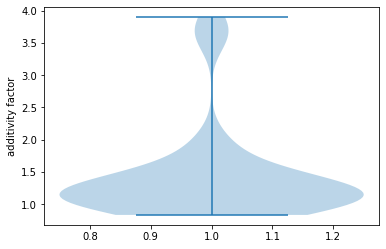

In [15]:
plt.violinplot(result["additivity_factor"])
plt.ylabel("additivity factor")
plt.show()

"The whole is more than the sum of its parts"

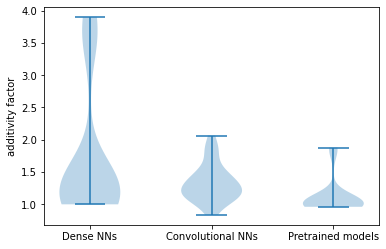

In [16]:
result_dense = result[result.loc[:,"config.model_file"] == "dataset.models.dense"]
result_conv = result[result.loc[:,"config.model_file"] == "dataset.models.conv"]
result_pretrained = result[result.loc[:,"config.model_file"] == "dataset.models.pretrained"]
results = [result_dense, result_conv, result_pretrained]

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.violinplot([res["additivity_factor"] for res in results])
ax1.set_xticks([1,2,3], labels = ["Dense NNs", "Convolutional NNs", "Pretrained models"])
ax1.set_ylabel("additivity factor")
plt.show()
                

# Different model types
Let us now look in more detail at the different types of models in our dataset:

In [17]:
result_dense = result[result.loc[:,"config.model_file"] == "dataset.models.dense"]
result_conv = result[result.loc[:,"config.model_file"] == "dataset.models.conv"]
result_pretrained = result[result.loc[:,"config.model_file"] == "dataset.models.pretrained"]


## Fully connected NNs

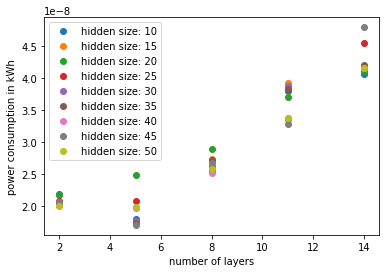

In [18]:
%matplotlib inline
for hidden_size in range(10,51,5):
    vis = result_dense[result_dense.loc[:,"config.params.hidden_size"] == hidden_size]
    plt.plot(vis["config.params.number_layers"], vis["result.power"], "o", label = f"hidden size: {hidden_size}")
plt.legend()
plt.xlabel("number of layers")
plt.ylabel("power consumption in kWh")
plt.show()

One can see that the hidden size of a fully connected network seems to have no influence on the power consumption. In contrast, the number of layers seems to be linearly correlated with the power consumption.

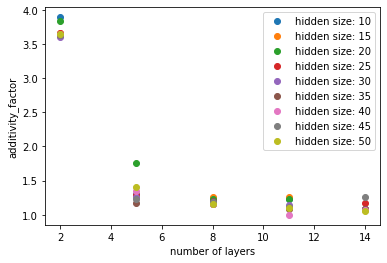

In [19]:
for hidden_size in range(10,51,5):
    vis = result_dense[result_dense.loc[:,"config.params.hidden_size"] == hidden_size]
    plt.plot(vis["config.params.number_layers"], vis["additivity_factor"], "o", label = f"hidden size: {hidden_size}")
plt.legend()
plt.xlabel("number of layers")
plt.ylabel("additivity_factor")
plt.show()

So the very high additivity factor of 4 seems to only occur for two layers. Not sure why.

## Convolutional NNs

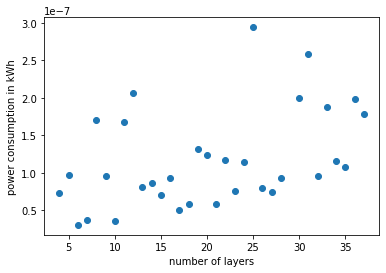

In [20]:
plt.plot(result_conv["config.params.number_layers"], result_conv["result.power"], "o")
plt.xlabel("number of layers")
plt.ylabel("power consumption in kWh")
plt.show()

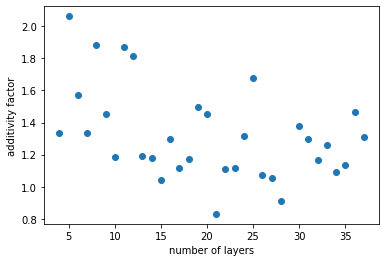

In [21]:
plt.plot(result_conv["config.params.number_layers"], result_conv["additivity_factor"], "o")
plt.xlabel("number of layers")
plt.ylabel("additivity factor")
plt.show()

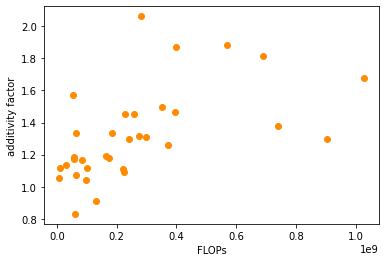

In [22]:
plt.plot(result_conv["FLOPs"], result_conv["additivity_factor"], "o", color = "darkorange")
plt.xlabel("FLOPs")
plt.ylabel("additivity factor")
plt.show()

## Pretrained Models

In [31]:
result["layers"] = result.apply(lambda x: len(x["model"].layers), axis = 1)
result_pretrained = result[result.loc[:,"config.model_file"] == "dataset.models.pretrained"]

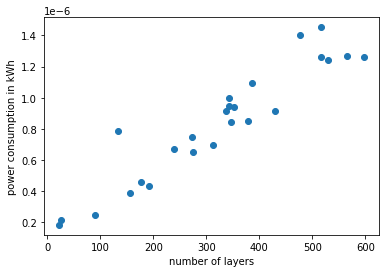

In [32]:
plt.plot(result_pretrained["layers"], result_pretrained["result.power"], "o")
plt.xlabel("number of layers")
plt.ylabel("power consumption in kWh")
plt.show()

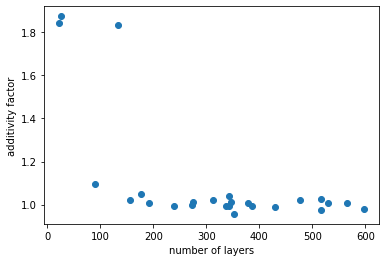

In [33]:
plt.plot(result_pretrained["layers"], result_pretrained["additivity_factor"], "o")
plt.xlabel("number of layers")
plt.ylabel("additivity factor")
plt.show()

In [34]:
result_pretrained["result.name"]

78          DenseNet121
79          DenseNet169
80       EfficientNetB0
81       EfficientNetB1
82       EfficientNetB2
83       EfficientNetB3
84       EfficientNetB4
85     EfficientNetV2B0
86     EfficientNetV2B1
87     EfficientNetV2B2
88      EfficientNetV2S
89          InceptionV3
90            MobileNet
91          MobileNetV2
92            ResNet101
93          ResNet101V2
94            ResNet152
95          ResNet152V2
96             ResNet50
97           ResNet50V2
98          ResNetRS101
99           ResNetRS50
100               VGG16
101               VGG19
102            Xception
Name: result.name, dtype: object

# Layer analysis

In [61]:
conv_pretrained = []
conv_simple = []
pool_pretrained = []
pool_simple = []
dense_simple = []
dense_pretrained = []

for _,x in result.iterrows():
    for layer, power in zip(x["model"].layers, x["result.power_layerwise"]):
        if x["result.type"] == "simple":
            if "dense" in layer.__class__.__name__.lower():
                dense_simple.append(power)
            elif "conv" in layer.__class__.__name__.lower():
                conv_simple.append(power)
            elif "pool" in layer.__class__.__name__.lower():
                pool_simple.append(power)
        else:
            if "dense" in layer.__class__.__name__.lower():
                dense_pretrained.append(power)
            elif "conv" in layer.__class__.__name__.lower():
                conv_pretrained.append(power)
            elif "pool" in layer.__class__.__name__.lower():
                pool_pretrained.append(power)

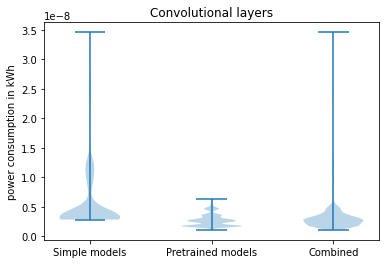

In [76]:
#Remove one outlier:

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.violinplot([conv_simple, conv_pretrained, conv_simple + conv_pretrained])
plt.ylabel("power consumption in kWh")
ax1.set_xticks([1,2,3], labels = ["Simple models", "Pretrained models", "Combined"])
plt.title("Convolutional layers")
fig.show()

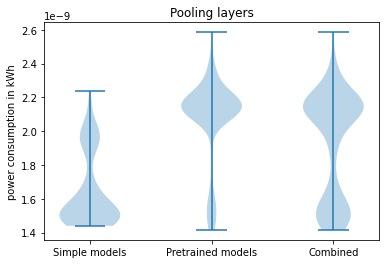

In [75]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.violinplot([pool_simple, pool_pretrained, pool_simple + pool_pretrained])
plt.ylabel("power consumption in kWh")
ax1.set_xticks([1,2,3], labels = ["Simple models", "Pretrained models", "Combined"])
plt.title("Pooling layers")
fig.show()

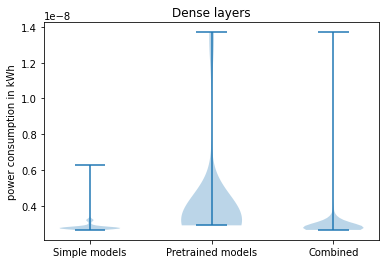

In [67]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.violinplot([dense_simple, dense_pretrained, dense_simple + dense_pretrained])
plt.ylabel("power consumption in kWh")
#ax1.set_ylim(0,2e-8)
ax1.set_xticks([1,2,3], labels = ["Simple models", "Pretrained models", "Combined"])
plt.title("Dense layers")
fig.show()